In [1]:
# Hello World!
print('Hello World')

Hello World


### Colab 에서 pyTorch 를 사용하기 위해 설치하는 과정입니다.

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

### pyTorch 를 비롯해 오늘 실습에 필요한 파이썬 라이브러리를 읽어들입니다.

In [0]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F #
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 패키지입니다.

# MNIST Feed-Forward Neural Network for a classification

## Data Loader 불러오기

---


- 물음표 2곳 채우기

In [0]:
mnist_train = vision_dsets.MNIST(root = './',  #root 는 데이터의 저장 위치 입니다. 
									train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
									transform = T.ToTensor(), # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
									download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 

In [12]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [0]:
def MNIST_DATA(root='./', train=True, transforms=None, download =True,batch_size=32, num_worker=1):

	print ("[+] Get the MNIST DATA")
	"""
  	torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다. 
  	Machine Learning 에서 Hello world 라고 불리는 Mnist 데이터를 사용해 보겠습니다. 
  
	"""
	mnist_train = vision_dsets.MNIST(root = root,  #root 는 데이터의 저장 위치 입니다. 
									train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
									transform = T.ToTensor(), # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
									download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
	mnist_test = vision_dsets.MNIST(root = root,
									train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
									transform = T.ToTensor(),
									download = True)
	"""
  	Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
  	* Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
  	커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
  
	"""
	trainDataLoader = data.DataLoader(dataset = mnist_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
									batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
									shuffle = True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
									num_workers = 1) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

	testDataLoader = data.DataLoader(dataset = mnist_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
									batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
									shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
									num_workers = 1) #
	print ("[+] Finished loading data & Preprocessing")
	return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [25]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 를 불러 옵니다. 
print('[info] # of train batch : ', len(trainDataLoader)) # 60000개 이미지
print('[info] # of test batch : ', len(testDataLoader)) # 10016개 이미지

device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch0.4.0 이상 버젼에서 gpu 설정하는 방식, tensor.to(device) 이런식으로 사용

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing
[info] # of train batch :  1875
[info] # of test batch :  313


In [28]:
dir(trainDataLoader.dataset.train_data.shaep)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 'download',
 'processed_folder',
 'raw_folder',
 'root',
 'target_transform',
 'test_file',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'urls']

In [30]:
print(trainDataLoader.dataset.train_data.shape)

torch.Size([60000, 28, 28])


In [33]:
type(trainDset.train_labels)

torch.Tensor

In [32]:
type(trainDset)

torchvision.datasets.mnist.MNIST

In [20]:
trainDset.info()

AttributeError: ignored

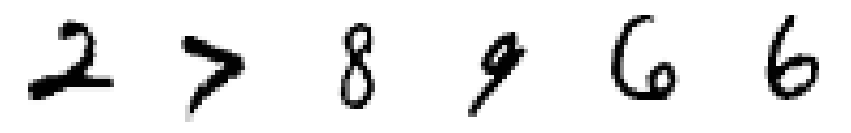

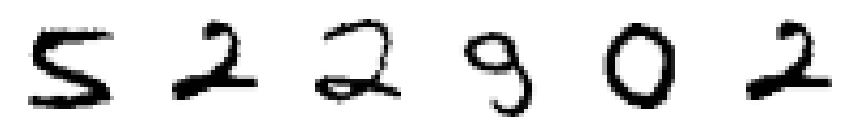

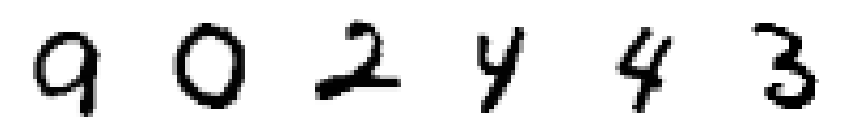

In [0]:
def showImages(image, row):
  
  for _ in range(row):  
  
    idx = np.random.choice(32, 6)     # 0 ~ 31 의 정수 중 6 개를 임의로 선택
    images =image.numpy()[idx]         # 선택된 index 에 해당하는 이미지를 가져옴
    
    plt.figure(figsize = (15, 90))     # 세로 길이 15, 가로 길이 15 * 6 의 화면 생성
    
    for i in range(161, 167):    
    
      plt.subplot(i)
      plt.imshow(images[i - 161])
      plt.xticks([])
      plt.yticks([])    
    
    plt.show()  

for i, (image, labels) in enumerate(trainDataLoader): 
  
  showImages(image.squeeze(), 3)
  break

## Train Function

In [0]:
def train_network(net,optimizer,trainloader):
  for epoch in range(5):  # loop over the dataset multiple times

      running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
      for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
          # get the inputs
          inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
          inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다. Q) 이걸 안 한다면? --> activation memory 가 터진다. 
                                   # forward 했을 떄 5000이 나오고, 안비워준다면 backpropagation 할때 5000더 추가되서 메모리에 부하

          # forward + backward + optimize
          outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다. 
          loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
          loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
          optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 

          # print statistics
          running_loss += loss.data[0]
          if (i+1) % 500 == 0:    # print every 500 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

  print('Finished Training')

## Test Function

In [0]:
def test(model,test_loader):
  model.eval() # Eval Mode 왜 해야 할까요?  --> nn.Dropout BatchNorm 등의 Regularization 들이 test 모드로 들어가게 되기 때문입니다. 
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)  # 기존의 train function의 data 처리부분과 같습니다.  
    output = model(data) 
    pred = output.max(1, keepdim=True)[1] # get the index of the max 
    correct += pred.eq(target.view_as(pred)).sum().data[0] # 정답 데이터의 갯수를 반환합니다. 

  test_loss /= len(test_loader.dataset)
  print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

## Neural Network  + Activation Function

### 간단한 Neural Network 를 만들어 봅시다. (1)
특징 : 2개의 Layer를 가지는 Neural Network 
<구성>  
Layer 1 - input:28*28 , output : 30 + Activation Fucntion - Sigmoid 

Layer 2 - input: 30 output:10

Cross Entropy Loss  + SGD optimizer


---

물음표 1곳 채우기

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() # nn.Module 생성자 호출이 왜 필요할까요? nn.Module 을 상속받아서 부모의 메소드를 쓰기 위해서 상속 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view함수는 주어진 인자의 크기로 해당 데이터의 크기를 반환합니다. 즉, (Batch_size,28,28) --> (Batch_size,28*28)로 변환합니다.
        x = F.sigmoid(self.fc0(x)) # 28*28 -> 30 -> Activation function 을 수행합니다.
        # linear layer 2ro --> linear layer 로 한개로 퉁처짐
        # 따라서 non-linear 하게 하기 위해서 activation 함수를 써준다. 
        x = self.fc1(x)  # 30 -> 10 으로 10개의 Class에 대한 logit 값을 호출합니다. 
        return x

### Optimizer 
Optimizer 의 경우 기본적으로 torch.optim 안에 존재합니다. 다양한 optimziers 가 정의되어 있습니다. 

기본적으로 다음과 같은 구성을 따릅니다. optim.{Optimzier 이름}({Network Parameters},lr ={learning rate })

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [11]:
train_network(mnist_net,optimizer,trainDataLoader) # 4 Epoch 정도 학습을 진행해봅니다. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 2.311
[1,  1000] loss: 2.294
[1,  1500] loss: 2.279
[2,   500] loss: 2.258
[2,  1000] loss: 2.247
[2,  1500] loss: 2.236
[3,   500] loss: 2.216
[3,  1000] loss: 2.203
[3,  1500] loss: 2.189
[4,   500] loss: 2.165
[4,  1000] loss: 2.148
[4,  1500] loss: 2.135
[5,   500] loss: 2.101
[5,  1000] loss: 2.084
[5,  1500] loss: 2.065
Finished Training


In [12]:
test(mnist_net,testDataLoader) # Test 정확도를 출력해 봅니다. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 6205/10000 (62%)



### 간단한 Neural Network 를 만들어 봅시다. (2)
특징 : 2개의 Layer를 가지는 Neural Network 
<구성>  
Layer 1 - input:28*28 , output : 30 + Activation Fucntion - tanh 

Layer 2 - input: 30 output:10

Cross Entropy Loss  + SGD optimizer 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view함수는 주어진 인자의 크기로 해당 데이터의 크기를 반환합니다. 즉, (Batch_size,28,28) --> (Batch_size,28*28)로 변환합니다.
        x = F.tanh(self.fc0(x)) # 28*28 -> 30 -> Activation function 을 수행합니다.
        x = self.fc1(x)  # 30 -> 10 으로 10개의 Class에 대한 logit 값을 호출합니다. 
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [16]:
train_network(mnist_net,optimizer,trainDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 2.222
[1,  1000] loss: 2.068
[1,  1500] loss: 1.922
[2,   500] loss: 1.682
[2,  1000] loss: 1.553
[2,  1500] loss: 1.452
[3,   500] loss: 1.275
[3,  1000] loss: 1.189
[3,  1500] loss: 1.123
[4,   500] loss: 1.004
[4,  1000] loss: 0.965
[4,  1500] loss: 0.918
[5,   500] loss: 0.845
[5,  1000] loss: 0.820
[5,  1500] loss: 0.779
Finished Training


In [17]:
test(mnist_net,testDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 8416/10000 (84%)



![대체 텍스트](https://taewanmerepo.github.io/2017/12/tanh/010.jpg)
![대체 텍스트](https://taewanmerepo.github.io/2017/12/tanh/020.jpg)

### 간단한 Neural Network 를 만들어 봅시다. (3)
특징 : 2개의 Layer를 가지는 Neural Network 
<구성>  
Layer 1 - input:28*28 , output : 30 + Activation Fucntion - Relu

Layer 2 - input: 30 output:10

Cross Entropy Loss  + SGD optimizer 


In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        # If the size is a square you can only specify a single number
        x = x.view(-1,28*28)
        x = F.relu(self.fc0(x))
        x = self.fc1(x)
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(mnist_net,optimizer,trainDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 2.281
[1,  1000] loss: 2.199
[1,  1500] loss: 2.104
[2,   500] loss: 1.899
[2,  1000] loss: 1.758
[2,  1500] loss: 1.605
[3,   500] loss: 1.358
[3,  1000] loss: 1.224
[3,  1500] loss: 1.104
[4,   500] loss: 0.961
[4,  1000] loss: 0.884
[4,  1500] loss: 0.833
[5,   500] loss: 0.761
[5,  1000] loss: 0.713
[5,  1500] loss: 0.679
[6,   500] loss: 0.629
[6,  1000] loss: 0.617
[6,  1500] loss: 0.602
[7,   500] loss: 0.563
[7,  1000] loss: 0.544
[7,  1500] loss: 0.541
[8,   500] loss: 0.521
[8,  1000] loss: 0.500
[8,  1500] loss: 0.498
[9,   500] loss: 0.488
[9,  1000] loss: 0.468
[9,  1500] loss: 0.463
[10,   500] loss: 0.455
[10,  1000] loss: 0.449
[10,  1500] loss: 0.434
Finished Training


In [0]:
test(mnist_net,testDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 8927/10000 (89%)



![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*g0yxlK8kEBw8uA1f82XQdA.png)

### 간단한 Neural Network 를 만들어 봅시다. (4) 
특징 : 3개의 Layer를 가지는 Neural Network 
<구성>  
Activation Fucntion - sigmoid 

Layer 1 - input:28*28 , output : 40

Layer 2 - input: 40 output: 30

Layer 3 - input: 30 output : 10

Cross Entropy Loss  + SGD optimizer 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,40) # Layer 1
        self.fc1 = nn.Linear(40, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = F.sigmoid(self.fc0(x))
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [21]:
# 활성화 함수가 sigmoid 두개로 쌓아서 gradient descent 를 할때 값이 너무 작아짐. 즉 갱신하지를 못함 . (local 에 갇힘?)
train_network(mnist_net,optimizer,trainDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 2.320
[1,  1000] loss: 2.310
[1,  1500] loss: 2.304
[2,   500] loss: 2.301
[2,  1000] loss: 2.300
[2,  1500] loss: 2.300
[3,   500] loss: 2.300
[3,  1000] loss: 2.299
[3,  1500] loss: 2.298
[4,   500] loss: 2.299
[4,  1000] loss: 2.298
[4,  1500] loss: 2.297
[5,   500] loss: 2.297
[5,  1000] loss: 2.297
[5,  1500] loss: 2.297
Finished Training


In [22]:
test(mnist_net,testDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 1135/10000 (11%)



### 간단한 Neural Network 를 만들어 봅시다. (5) 
특징 : 3개의 Layer를 가지는 Neural Network 
<구성>  
Activation Fucntion - Relu 

Layer 1 - input:28*28 , output : 40

Layer 2 - input: 40 output: 30

Layer 3 - input: 30 output : 10

Cross Entropy Loss  + SGD optimizer 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,40) #Layer 1 
        self.fc1 = nn.Linear(40, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
       
        x = x.view(-1,28*28)
        x = F.relu(self.fc0(x)) # Layer 1
        x = F.relu(self.fc1(x)) # Layer 2
        x = self.fc2(x)
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(mnist_net,optimizer,trainDataLoader)

### 간단한 Neural Network 를 만들어 봅시다. (6) 
특징 : 3개의 Layer를 가지는 Neural Network 
<구성>  
Layer 1 - input:28*28 , output : 40 + Activation Fucntion - Relu 

Layer 2 - input: 40 output: 30

Layer 3 - input: 30 output : 10

Cross Entropy Loss  + **Adam** optimizer 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,40) #Layer 1 
        self.fc1 = nn.Linear(40, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
       
        x = x.view(-1,28*28)
        x = F.relu(self.fc0(x)) # Layer 1
        x = F.relu(self.fc1(x)) # Layer 2
        x = self.fc2(x) # Layer 3 
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(mnist_net,optimizer,trainDataLoader)

In [0]:
test(mnist_net,testDataLoader)

### 간단한 Neural Network 를 만들어 봅시다. (7) Batch Norm 을 줘 볼까요?
특징 : 2개의 Layer를 가지는 Neural Network

<구성>  

Layer 1 - input:28*28 , output : 40 + Activation Fucntion - Relu + BatchNorm

Layer 2 - input: 40 output: 30 + Activation Fucntion - Relu  + BatchNorm

Layer 3 - input: 30 output : 10

Cross Entropy Loss  + **Adam** optimizer 

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,40) #Layer 1 
        self.bn0 = nn.BatchNorm1d(40) #BatchNorm1 
        self.fc1 = nn.Linear(40, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) #BatchNorm1 
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
       
        x = x.view(-1,28*28)
        x = F.relu(self.bn0(self.fc0(x))) # Layer 1
        x = F.relu(self.bn1(self.fc1(x))) # Layer 2
        x = self.fc2(x)
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [25]:
train_network(mnist_net,optimizer,trainDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 0.816
[1,  1000] loss: 0.280
[1,  1500] loss: 0.230
[2,   500] loss: 0.164
[2,  1000] loss: 0.161
[2,  1500] loss: 0.155
[3,   500] loss: 0.131
[3,  1000] loss: 0.123
[3,  1500] loss: 0.133
[4,   500] loss: 0.110
[4,  1000] loss: 0.110
[4,  1500] loss: 0.114
[5,   500] loss: 0.101
[5,  1000] loss: 0.099
[5,  1500] loss: 0.099
Finished Training


In [26]:
test(mnist_net,testDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 9715/10000 (97%)



### Let's Do it - 성능을 한번 끝까지 높여볼까요~? 마음대로 한번 최고 성능을 찍어봅시다

In [0]:
class Diy_Net(nn.Module):
    def __init__(self):
        super(Diy_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,392) #Layer 1 
        self.bn0 = nn.BatchNorm1d(392) #BatchNorm1 
        self.fc1 = nn.Linear(392, 196) # Layer 2
        self.bn1 = nn.BatchNorm1d(196) #BatchNorm1 
        self.fc2 = nn.Linear(196, 98) # Layer 3
        self.bn2 = nn.BatchNorm1d(98) #BatchNorm1 
        self.fc3 = nn.Linear(98, 49) # Layer 4
        self.bn3 = nn.BatchNorm1d(49) #BatchNorm1 
        self.fc4 = nn.Linear(49, 25) # Layer 5
        self.bn4 = nn.BatchNorm1d(25) #BatchNorm1 
        self.fc5 = nn.Linear(25, 10) # Output Layter
        

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.bn0(self.fc0(x))) # Layer 1
        x = F.relu(self.bn1(self.fc1(x))) # Layer 2
        x = F.relu(self.bn2(self.fc2(x))) # Layer 3
        x = F.relu(self.bn3(self.fc3(x))) # Layer 4
        x = F.relu(self.bn4(self.fc4(x))) # Layer 5

        x = self.fc5(x)
        return x

##### 정답 : 자신을 위해 가능한 보지 말아주세요~

In [0]:
class Diy_Net(nn.Module):
    def __init__(self):
        super(Diy_Net, self).__init__()
        
        self.fc0 = nn.Linear(28*28,16*5*5)
        self.bn0 = nn.BatchNorm1d(16*5*5)
        self.fc1 = nn.Linear(16 * 5 * 5, 84)
        self.bn1 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      
        # If the size is a square you can only specify a single number
        x = x.view(-1,28*28)
        x = F.relu(self.bn0(self.fc0(x)))
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc3(x)
        return x

##### --

In [0]:
diy_net = Diy_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(diy_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [12]:
train_network(diy_net,optimizer,trainDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 0.809
[1,  1000] loss: 0.271
[1,  1500] loss: 0.210
[2,   500] loss: 0.147
[2,  1000] loss: 0.139
[2,  1500] loss: 0.130
[3,   500] loss: 0.094
[3,  1000] loss: 0.102
[3,  1500] loss: 0.103
[4,   500] loss: 0.078
[4,  1000] loss: 0.088
[4,  1500] loss: 0.084
[5,   500] loss: 0.067
[5,  1000] loss: 0.065
[5,  1500] loss: 0.064
Finished Training


In [22]:
test(diy_net,testDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 9794/10000 (97%)



## Practical Guide Pytorch nn.Sequential 



```
x = F.relu(self.bn0(self.fc0(x)))
x = F.relu(self.bn1(self.fc1(x)))
```
너무 복잡하지 않나요?  그냥 x = self.fc(x) 쉽게 해버리면 안 될까요?

Solution : nn.Sequential + 자매품 nn.ModuList


In [0]:
class Diy_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        
        layer_list = [] # 이 리스트에 모든 Layer 를 순차적으로 append 해보겠습니다. 
        layer_list.append(nn.Linear(28*28,40)) #Layer 1 
        layer_list.append(nn.BatchNorm1d(40))#BatchNorm1
        layer_list.append(nn.ReLU())
        '''
        layer 2: input dimension: 40, output dimension: 30, batchnorm, relu
        layer 3: input dimension: 30, output dimension: 10
        '''
        self.net  = nn.Sequential(*layer_list) # nn.Sequential 에 layer list를 넘겨 줍니다.
    def forward(self, x):
       
        x = x.view(-1,28*28)
        x = self.net(x) # 넣은 순서대로 적용이 됩니다. 
        return x

     self.fc0 = nn.Linear(28*28,392) #Layer 1 
        self.bn0 = nn.BatchNorm1d(392) #BatchNorm1 
        self.fc1 = nn.Linear(392, 196) # Layer 2
        self.bn1 = nn.BatchNorm1d(196) #BatchNorm1 
        self.fc2 = nn.Linear(196, 98) # Layer 3
        self.bn2 = nn.BatchNorm1d(98) #BatchNorm1 
        self.fc3 = nn.Linear(98, 49) # Layer 4
        self.bn3 = nn.BatchNorm1d(49) #BatchNorm1 
        self.fc4 = nn.Linear(49, 25) # Layer 5
        self.bn4 = nn.BatchNorm1d(25) #BatchNorm1 
        self.fc5 = nn.Linear(25, 10) # Output Layter

In [0]:
class Diy_Net(nn.Module):
  def __init__(self):
    super(Diy_Net, self).__init__()
    
    layer_list = []
    layer_list.append(nn.Linear(28*28, 392)) # layer 1
    layer_list.append(nn.BatchNorm1d(392)) #batchNorm1
    layer_list.append(nn.ReLU())
    
    layer_list.append(nn.Linear(392, 196)) #layer2
    layer_list.append(nn.BatchNorm1d(196))
    layer_list.append(nn.ReLU())
    
    layer_list.append(nn.Linear(196, 98)) #layer3
    layer_list.append(nn.BatchNorm1d(98))
    layer_list.append(nn.ReLU())
    
    layer_list.append(nn.Linear(98, 49)) #layer4
    layer_list.append(nn.BatchNorm1d(49))
    layer_list.append(nn.ReLU())
    
    layer_list.append(nn.Linear(49, 25)) #layer5
    layer_list.append(nn.BatchNorm1d(25))
    layer_list.append(nn.ReLU())
    
    layer_list.append(nn.Linear(25, 10)) # Output layer
    self.net  = nn.Sequential(*layer_list) # nn.Sequential 에 layer list를 넘겨 줍니다.
    
  def forward(self, x):

      x = x.view(-1,28*28)
      x = self.net(x) # 넣은 순서대로 적용이 됩니다. 
      return x
    

##### 정답 : 자신을 위해 가능한 보지 말아주세요~

In [0]:
class Diy_Net(nn.Module):
    def __init__(self):
        super(Diy_Net, self).__init__()
        
        layer_list = [] # 이 리스트에 모든 Layer 를 순차적으로 append 해보겠습니다. 
        layer_list.append(nn.Linear(28*28,40)) #Layer 1 
        layer_list.append(nn.BatchNorm1d(40))#BatchNorm1
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Linear(40, 30)) # Layer 2
        layer_list.append(nn.BatchNorm1d(30)) #BatchNorm1
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Linear(30, 10)) # Layer 3
        self.net  = nn.Sequential(*layer_list) # nn.Sequential 에 layer list를 넘겨 줍니다.
    def forward(self, x):
       
        x = x.view(-1,28*28)
        x = self.net(x) # 넣은 순서대로 적용이 됩니다. 
        return x

##### --

In [0]:
diy_net = Diy_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(diy_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [21]:
train_network(diy_net,optimizer,trainDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   500] loss: 0.838
[1,  1000] loss: 0.277
[1,  1500] loss: 0.208
[2,   500] loss: 0.139
[2,  1000] loss: 0.152
[2,  1500] loss: 0.131
[3,   500] loss: 0.106
[3,  1000] loss: 0.104
[3,  1500] loss: 0.098
[4,   500] loss: 0.076
[4,  1000] loss: 0.089
[4,  1500] loss: 0.087
[5,   500] loss: 0.060
[5,  1000] loss: 0.072
[5,  1500] loss: 0.071
Finished Training


In [23]:
test(diy_net,testDataLoader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 9794/10000 (97%)

